In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v1')

In [3]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(ActorCriticModel, self).__init__()
        self.fc = nn.Linear(n_input, n_hidden)
        self.action = nn.Linear(n_hidden, n_output)
        self.value = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = torch.Tensor(x)
        x = F.relu(self.fc(x))
        action_probs = F.softmax(self.action(x), dim=-1)
        state_values = self.value(x)
        return action_probs, state_values

In [4]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = ActorCriticModel(n_state, n_action, n_hidden)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)

    def predict(self, s):
        """
        Вычисляет выход, применяя модель исполнитель–критик
        @param s: входное состояние
        @return: вероятности действий, ценность состояния
        """
        return self.model(torch.Tensor(s))    
    
    def update(self, returns, log_probs, state_values):
        """
        Обновляет веса сети исполнитель–критик на основе переданных
        обучающих примеров
        @param returns: доход (накопительное вознаграждение) на
        каждом шаге эпизода
        @param log_probs: логарифм вероятности на каждом шаге
        @param state_values: ценности состояний на каждом шаге
        """
        loss = 0
        for log_prob, value, Gt in zip(log_probs, state_values, returns):
            advantage = Gt - value.item()
            policy_loss = -log_prob * advantage
            value_loss = F.smooth_l1_loss(value, Gt)
            loss += policy_loss + value_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, s):
        """
        Предсказывает стратегию, выбирает действие и вычисляет логарифм
        его вероятности
        @param s: входное состояние
        @return: выбранное действие и логарифм его вероятности
        """
        action_probs, state_value = self.predict(s)
        action = torch.multinomial(action_probs, 1).item()
        log_prob = torch.log(action_probs[action])
        return action, log_prob, state_value        

In [5]:
def actor_critic(env, estimator, n_episode, total_reward_episode, gamma=1.0):
    """
    Алгоритм исполнитель–критик
    @param env: имя окружающей среды Gym
    @param estimator: сеть стратегии
    @param n_episode: количество эпизодов
    @param gamma: коэффициент обесценивания
    """
    for episode in tqdm(range(n_episode)):
        log_probs = []
        rewards = []
        state_values = []
        state, _ = env.reset()
        while True:
            action, log_prob, state_value = estimator.get_action(state)
            next_state, reward, is_done, is_break, _ = env.step(action)
            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            state_values.append(state_value)
            rewards.append(reward)

            if is_done or is_break:
                returns = []
                Gt = 0
                pw = 0
                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)

                estimator.update(returns, log_probs, state_values)

                #print('Эпизод: {}, полное вознаграждение: {}'.format(episode, total_reward_episode[episode]))

                if total_reward_episode[episode] >= 195:
                    estimator.scheduler.step()
                break
     
            state = next_state

In [6]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

gamma = 0.9

n_episode = 1000
total_reward_episode = [0] * n_episode
actor_critic(env, policy_net, n_episode, total_reward_episode, gamma)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\v.tyumenev\AppData\Local\Temp\ipykernel_9616\2199464630.py:28: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, Gt)
100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


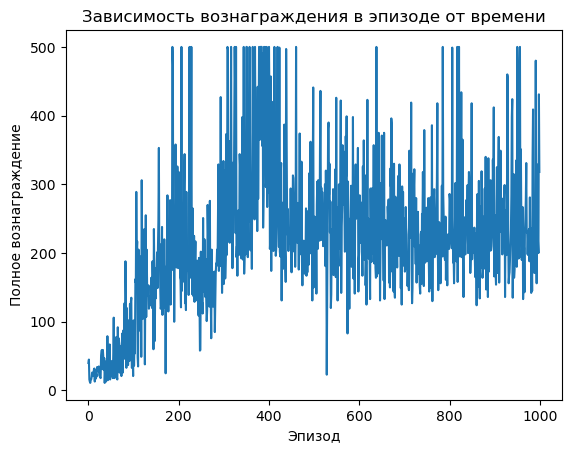

In [7]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()